# Implement a Bandit Advertising Recommender in Reco-Gym
## Ruoyan Kong, kong0135
This is a notebook showing the process of building a bandit involving at least three algorithms (they may be the built-in algorithms), and showing the improvement of that bandit over an algorithm that simply selects from the algorithms at random.

Reference: https://github.com/criteo-research/reco-gym

In [1]:
import gym, recogym
import numpy as np
from numpy.random import choice
from recogym.agents import Agent
import pandas as pd
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# env_0_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_args, Configuration

# You can overwrite environment arguments here:
env_1_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

# .reset() env before each episode (one episode per user).
env.reset()
num_products = 10

## Build 3 Recommender Algorithm
In this section we will build the 3 recommender algorithms that we will use in MAB --random recommender, popularity recommender, and epsilon recommender.

### RandomRecommender
The RandomRecommender recommend a product from all the potential products randomly with uniform probability.

In [2]:
class RandomRecommender():
    def __init__(self, num_products):
        self.num_products = num_products
        
    def process_feedback(self, item, reward):
        pass
    
    def recommend_product(self):
        return choice(self.num_products)

### GreedyRecommender
The GreedyRecommender always recommend the product with the probability in proportion to its reward collected (0.001 is the initial probability for it to try all the products).

In [3]:
class GreedyRecommender():
    def __init__(self, num_products):
        self.num_products = num_products
        self.product_reward = np.ones(num_products)*0.001
        
    def process_feedback(self,item, reward):
        if reward == 0:
            self.product_reward[item] -= 1
        else:
            self.product_reward[item] += reward
    
    def recommend_product(self):
        r = self.product_reward.clip(min=0)
        if np.count_nonzero(r) == 0:
            self.product_reward = np.ones(num_products)*0.001
        r = self.product_reward.clip(min=0)
        prob = r/np.sum(r)
            
#         if np.sum(self.product_reward) == 0:
#             prob = 1.0/self.num_products * np.ones(self.num_products)
#         else:
#             prob = self.product_reward/np.sum(self.product_reward)
        return choice(range(self.num_products), p=prob)

### EpsilonRecommender
The EpsilonRecommende recommend the product with the probability in proportion to its reward collected, however it can also recommend other products with a epsilon probability.

In [4]:
class EpsilonRecommender():
    def __init__(self, num_products):
        self.num_products = num_products
        self.product_reward = np.ones(num_products)*0.1
        
    def process_feedback(self,item, reward):
        if reward == 0:
            self.product_reward[item] -= 1
        else:
            self.product_reward[item] += reward
    
    def recommend_product(self):
        r = self.product_reward.clip(min=0)
        if np.count_nonzero(r) == 0:
            self.product_reward = np.ones(num_products)*0.001
        r = self.product_reward.clip(min=0)
        prob = r/np.sum(r)
            
#         if np.sum(self.product_reward) == 0:
#             prob = 1.0/self.num_products * np.ones(self.num_products)
#         else:
#             prob = self.product_reward/np.sum(self.product_reward)
        return choice(range(self.num_products), p=prob)

## Bandit Recommender
In this section we implement 3 bandit recommender agent (RandomAgent -- baseline (non-learning) bandit, PopularityAgent, PopularityExposureAgent), and 1 agent represented the random algorithm (always choose the RandomRecommender).

The code is changed based on https://github.com/criteo-research/reco-gym/blob/master/Getting%20Started.ipynb.

### RandomAlgorithm
RandomAlgorithm always implement the RandomRecommender (choose a product randomly).

In [5]:
# Define an Agent class.
class RandomAlgorithm(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(RandomAlgorithm, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = np.zeros(self.config.num_products)
        self.arms = {'RR': RandomRecommender(self.config.num_products)}
        
    def reset_rec(self):
        self.arms = {'RR': RandomRecommender(self.config.num_products)
                    } 

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            for session in observation.sessions():
                self.organic_views[session['v']] += 1
                for arm_name in self.arms.keys():
                    self.arms[arm_name].process_feedback(session['v'], 1)
        for arm_name in self.arms.keys():
            self.arms[arm_name].process_feedback(action['a'], reward)
                    

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion with number of views.
        prob = 1.0/len(self.arms) * np.ones(len(self.arms))
        action = choice(list(self.arms.keys()), p = prob)
        a = self.arms[action].recommend_product()
        ind = list(self.arms.keys()).index(action)

        return {
            **super().act(observation, reward, done),
            **{
                'a': a,
                'a_name': action,
                'ps': prob[ind]
            }
        }

### RandomAgent
RandomAgent (notice it's different from the RandomAlgorithm, it does not only implement RandomRecommender) implement RandomRecommender, GreedyRecommender, EpsilonRecommender with 1/3 probability each. It's a non-learning recommender.

In [6]:
# Define an Agent class.
class RandomAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(RandomAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = np.zeros(self.config.num_products)
        self.arms = {'RR': RandomRecommender(self.config.num_products),
                     'GR': GreedyRecommender(self.config.num_products),
                     'ER': EpsilonRecommender(self.config.num_products)}
    def reset_rec(self):
        self.arms = {'RR': RandomRecommender(self.config.num_products),
                     'GR': GreedyRecommender(self.config.num_products),
                     'ER': EpsilonRecommender(self.config.num_products)} 

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            for session in observation.sessions():
                self.organic_views[session['v']] += 1
                for arm_name in self.arms.keys():
                    self.arms[arm_name].process_feedback(session['v'], 1)
        for arm_name in self.arms.keys():
            self.arms[arm_name].process_feedback(action['a'], reward)
                    

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion with number of views.
        prob = 1.0/len(self.arms) * np.ones(len(self.arms))
        action = choice(list(self.arms.keys()), p = prob)
        a = self.arms[action].recommend_product()
        ind = list(self.arms.keys()).index(action)

        return {
            **super().act(observation, reward, done),
            **{
                'a': a,
                'a_name': action,
                'ps': prob[ind]
            }
        }

### PopularityAgent
PopularityAgent records merely how many times an algorithm get reward, then when required to make a recommendation, the agent chooses a recommender randomly in proportion with the reward it gets.

In [7]:
# Define an Agent class.
class PopularityAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(PopularityAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = np.zeros(self.config.num_products)
        self.arms = {'RR': RandomRecommender(self.config.num_products),
                     'GR': GreedyRecommender(self.config.num_products),
                     'ER': EpsilonRecommender(self.config.num_products)}
        self.arm_reward = {'RR': 0,
                     'GR': 0,
                     'ER': 0}  
        self.eps = 0.2
        
    def reset_rec(self):
        self.arms = {'RR': RandomRecommender(self.config.num_products),
                     'GR': GreedyRecommender(self.config.num_products),
                     'ER': EpsilonRecommender(self.config.num_products)} 

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            for session in observation.sessions():
                self.organic_views[session['v']] += 1
                for arm_name in self.arms.keys():
                    self.arms[arm_name].process_feedback(session['v'], 1)
        for arm_name in self.arms.keys():
            self.arms[arm_name].process_feedback(action['a'], reward)
        self.arm_reward[action['a_name']] += reward
                    

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion with number of views.
        reward = np.array(list(self.arm_reward.values()))
        prob = np.zeros(len(self.arms))
        if np.sum(reward) == 0:
            prob = 1.0/len(self.arms) * np.ones(len(self.arms))
        else:
            no_reward_group = [i for i in range(len(reward)) if reward[i] == 0]
            if no_reward_group:
                for i in range(len(reward)):
                    if i in no_reward_group:
                        prob[i] = self.eps / len(no_reward_group)
                    else:
                        prob[i] = (1-self.eps)*reward[i]/np.sum(reward) 
            else:
                for i in range(len(reward)):
                    prob[i] = reward[i]/np.sum(reward) 

        action = choice(list(self.arms.keys()), p = prob)
        a = self.arms[action].recommend_product()
        ind = list(self.arms.keys()).index(action)

        return {
            **super().act(observation, reward, done),
            **{
                'a': a,
                'a_name': action,
                'ps': prob[ind]
            }
        }

### PopularityExposureAgent
Unlike the PopularityAgent, the PopularityExposureAgent considers how many times a Recommender has been took (if a Recommender get some reward, but was took for many times, then it may not be a very good Recommender on average). It considers the average reward of each Recommedner, uses these average rewards as weight to select the Recommender to use.

In [8]:
# Define an Agent class.
class PopularityExposureAgent(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(PopularityExposureAgent, self).__init__(config)

        # Track number of times each item viewed in Organic session.
        self.organic_views = np.zeros(self.config.num_products)
        self.arms = {'RR': RandomRecommender(self.config.num_products),
                     'GR': GreedyRecommender(self.config.num_products),
                     'ER': EpsilonRecommender(self.config.num_products)}
        self.arm_reward = {'RR': 0,
                     'GR': 0,
                     'ER': 0}     
        self.arm_exposure = {'RR': 0,
                     'GR': 0,
                     'ER': 0} 
        self.arm_avg_reward = {'RR': 0,
                     'GR': 0,
                     'ER': 0} 
        
    def reset_rec(self):
        self.arms = {'RR': RandomRecommender(self.config.num_products),
                     'GR': GreedyRecommender(self.config.num_products),
                     'ER': EpsilonRecommender(self.config.num_products)}        

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Adding organic session to organic view counts.
        if observation:
            for session in observation.sessions():
                self.organic_views[session['v']] += 1
                for arm_name in self.arms.keys():
                    self.arms[arm_name].process_feedback(session['v'], 1)
        for arm_name in self.arms.keys():
            self.arms[arm_name].process_feedback(action['a'], reward)
        self.arm_reward[action['a_name']] += reward
        self.arm_exposure[action['a_name']] += 1
        self.arm_avg_reward[action['a_name']] = self.arm_reward[action['a_name']] / self.arm_exposure[action['a_name']]
                    

    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion with number of views.
        reward = np.array(list(self.arm_avg_reward.values()))
        exposure = np.array(list(self.arm_exposure.values()))
        prob = np.zeros(len(self.arms))
        if np.sum(exposure) == 0:
            prob = 1.0/len(self.arms) * np.ones(len(self.arms))
        else:
            no_exposure_group = [i for i in range(len(exposure)) if exposure[i] == 0]
            no_reward_group = {i:1.0/exposure[i] for i in range(len(reward)) if reward[i] == 0 
                               and i not in no_exposure_group}
            reward_group = {i:reward[i] for i in range(len(reward)) if reward[i] != 0}
            s = sum(list(no_reward_group.values()))
            if no_exposure_group:
                if no_reward_group:
                    for i in range(len(reward)):
                        if i in no_exposure_group:
                            prob[i] = 0.5 / len(no_exposure_group)
                        elif i in no_reward_group.keys():
                            if reward_group:
                                prob[i] = 0.1 * no_reward_group[i] / s
                            else:
                                prob[i] = 0.5 * no_reward_group[i] / s
                        else:
                            prob[i] = 0.4 *reward[i]/np.sum(reward)   
                else:
                    for i in range(len(reward)):
                        if i in no_exposure_group:
                            prob[i] = 0.5 / len(no_exposure_group)
                        else:
                            prob[i] = 0.5 *reward[i]/np.sum(reward)                      
            else:
                if no_reward_group:
                    if reward_group:
                        for i in range(len(reward)):
                            if i in list(no_reward_group.keys()):
                                prob[i] = 0.1 * no_reward_group[i] / s
                            else:
                                prob[i] = 0.9 * reward[i] / np.sum(reward)    
                    else:
                        for i in range(len(reward)):
                            prob[i] = no_reward_group[i] / s                         
                else:
                    for i in range(len(reward)):
                        prob[i] = reward[i] / np.sum(reward)                            
            
        action = choice(list(self.arms.keys()), p = prob)
        a = self.arms[action].recommend_product()
        ind = list(self.arms.keys()).index(action)

        return {
            **super().act(observation, reward, done),
            **{
                'a': a,
                'a_name': action,
                'ps': prob[ind]
            }
        }

## Results
In this section we compare the results of the performance (CTR) of popularity bandit (PopularityAgent), the baseline (non-learning) bandit (RandomAgent), and the random algorithm, the improved bandit (PopularityExposureAgent).

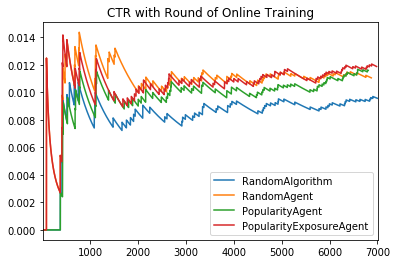

In [14]:
import pandas as pd
agent_list = {
    'RandomAlgorithm': RandomAlgorithm(Configuration({
                        **env_1_args,
                        'num_products': num_products,
                    })),
    'RandomAgent': RandomAgent(Configuration({
                        **env_1_args,
                        'num_products': num_products,
                    })),
    'PopularityAgent': PopularityAgent(Configuration({
                        **env_1_args,
                        'num_products': num_products,
                    })),
    'PopularityExposureAgent': PopularityExposureAgent(Configuration({
                        **env_1_args,
                        'num_products': num_products,
                    }))
}
ctr_data = pd.DataFrame(columns=agent_list.keys(),index = range(1,7002))
ctr_final_res = []
for agent_name in agent_list.keys():
    agent = agent_list[agent_name]

    # Resets random seed back to 42, or whatever we set it to in env_0_args.
    env.reset_random_seed()

    # Train on 1000 users offline.
    num_offline_users = 1000

    num_online_users = 100
    num_clicks, num_events = 0, 0
    
    for _ in range(num_online_users):

        # Reset env and set done to False.
        env.reset()
        observation, _, done, _ = env.step(None)
        reward = None
        done = None
        while not done:
            old_observation = observation
            action = agent.act(observation, reward, done)

            observation, reward, done, info = env.step(action['a'])
            agent.train(old_observation, action, reward, done)
            # Used for calculating click through rate.
            num_clicks += 1 if reward == 1 and reward is not None else 0
            num_events += 1
            ctr_data.loc[num_events, agent_name] = num_clicks / num_events
        agent.reset_rec()
        
    ctr = num_clicks / num_events
    ctr_final_res.append(ctr)
ctr_data.plot(title="CTR with Round of Online Training")


We can see that PopularityAgent and RopularityExposureAgent learn from the data and its performance improved gradually, while RandomAgent and RandomAlgorithm keeps the same level of CTR after 1000 rounds.

Then we show the average CTR of each bandit and algorithm. Here we can see that PopularityExposureAgent performs the best, and RandomAlgorithm performs the worse. The PopularityAgent is a little better than the RandomAgent.

,Agent,CTR
0,RandomAlgorithm,0.009576
1,RandomAgent,0.011061
2,PopularityAgent,0.011606
3,PopularityExposureAgent,0.011888


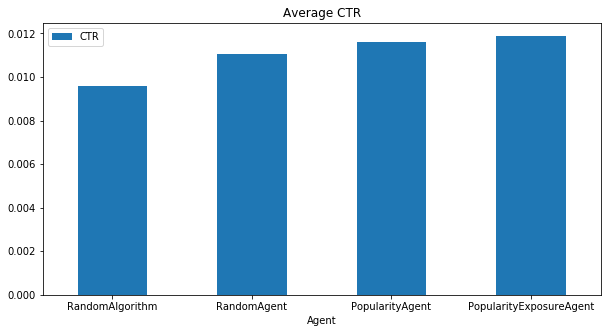

In [15]:
df = pd.DataFrame({'Agent':list(agent_list.keys()), 'CTR':ctr_final_res})
df.plot.bar(x='Agent', y='CTR', rot=0, title='Average CTR', figsize=(10,5))
df